In [6]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import random
from collections import defaultdict
import copy

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

In [10]:
import csv
freq = {}

with open("results.csv", "r", newline="") as file:
    reader = csv.reader(file)

    next(reader)

    for row in reader:
        edge = tuple(map(int, row[0].split('-')))
        frequency = int(row[1])

        freq[edge] = frequency

In [11]:
def sort_into_quantile_bins(freq, num_bins):
    # Step 1: Sort data by value
    sorted_freq = sorted(freq.items(), key=lambda x: x[1])
    
    # Step 2: Determine the number of elements per bin
    total_elements = len(sorted_freq)
    bin_size = total_elements // num_bins
    
    # Step 3: Assign elements to bins
    bins = defaultdict(list)
    bin_index = 1
    for i, (key, value) in enumerate(sorted_freq):
        bins[bin_index].append(key)
        if (i + 1) % bin_size == 0 and bin_index < num_bins:
            bin_index += 1
            
    return bins


num_bins = 10
bins = sort_into_quantile_bins(freq, num_bins)
for bin in bins.values():
    print(bin)

[(7, 208), (88, 1732), (176, 231), (306, 973), (179, 197), (1072, 1725), (202, 1345), (215, 2045), (239, 887), (273, 374), (285, 502), (109, 289), (312, 1610), (312, 1722), (312, 1740), (314, 1623), (320, 348), (417, 1072), (1072, 1483), (752, 2083), (372, 1710), (372, 1834), (191, 382), (387, 519), (388, 1899), (407, 409), (407, 1681), (711, 2113), (416, 519), (306, 417), (441, 2094), (306, 476), (482, 2307), (399, 544), (544, 1769), (547, 598), (553, 745), (306, 554), (554, 685), (306, 573), (581, 1623), (594, 663), (598, 1003), (603, 1248), (728, 1070), (661, 1045), (707, 763), (702, 777), (1070, 1072), (742, 1483), (742, 1620), (742, 1743), (118, 1538), (816, 2282), (868, 988), (220, 913), (915, 1740), (1012, 1681), (978, 1358), (524, 979), (530, 1013), (1013, 1842), (1070, 1358), (306, 1804), (1123, 1358), (1131, 1224), (1131, 2282), (401, 1160), (1222, 1224), (493, 1244), (1296, 1910), (1356, 1613), (1363, 1413), (1370, 1525), (1371, 1393), (518, 1373), (748, 1374), (1444, 2323),

In [12]:
def generate_perturbations(data, edges_to_remove):
    data = copy.deepcopy(data)
    edges = data.edge_index.t()
    
    edges_set = set(map(tuple, edges.numpy()))
    remove_set = set(map(tuple, edges_to_remove.numpy()))

    keep_edges = edges_set - remove_set
    keep_edges = torch.tensor(list(keep_edges)).t()
    data.edge_index = keep_edges
    
    return data


def make_undirected(lst):
    lst = torch.tensor(lst)
    flipped = lst.flip(dims=[1])
    combined = torch.cat((lst, flipped), dim=0)
    return combined

In [13]:
from torch_geometric.nn import GATConv
import torch.nn.functional as F


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=1)
)


In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      out = F.softmax(out, dim=1)
      pred = out.argmax(dim=1)
      correct = pred[mask] == data.y[mask]
      acc = int(correct.sum()) / int(mask.sum())
      return acc

In [15]:
for epoch in range(1, 101):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 1.9438, Val: 0.3780, Test: 0.4090
Epoch: 002, Loss: 1.9364, Val: 0.5680, Test: 0.5890
Epoch: 003, Loss: 1.9266, Val: 0.6180, Test: 0.6180
Epoch: 004, Loss: 1.9165, Val: 0.6200, Test: 0.6210
Epoch: 005, Loss: 1.9050, Val: 0.6620, Test: 0.6550
Epoch: 006, Loss: 1.8944, Val: 0.7160, Test: 0.7260
Epoch: 007, Loss: 1.8821, Val: 0.7680, Test: 0.7490
Epoch: 008, Loss: 1.8728, Val: 0.7700, Test: 0.7710
Epoch: 009, Loss: 1.8592, Val: 0.7940, Test: 0.7860
Epoch: 010, Loss: 1.8463, Val: 0.7960, Test: 0.7880
Epoch: 011, Loss: 1.8381, Val: 0.7980, Test: 0.7830
Epoch: 012, Loss: 1.8246, Val: 0.7960, Test: 0.7790
Epoch: 013, Loss: 1.8105, Val: 0.7960, Test: 0.7790
Epoch: 014, Loss: 1.7909, Val: 0.7920, Test: 0.7770
Epoch: 015, Loss: 1.7859, Val: 0.7880, Test: 0.7760
Epoch: 016, Loss: 1.7616, Val: 0.7860, Test: 0.7760
Epoch: 017, Loss: 1.7493, Val: 0.7880, Test: 0.7780
Epoch: 018, Loss: 1.7317, Val: 0.7900, Test: 0.7760
Epoch: 019, Loss: 1.7235, Val: 0.7900, Test: 0.7770
Epoch: 020, 

In [24]:
def get_logit_diff(perturbed_data):
    model.eval()
    out_orig = model(data.x, data.edge_index)
    out_perturb = model(data.x, perturbed_data.edge_index)
    logit_diff = out_orig - out_perturb
    l2_norm = torch.norm(logit_diff, p=2) / torch.norm(data.x, p=2)
    return l2_norm

In [25]:
num_samples = 10

results = torch.zeros(num_bins, num_samples)

for i, bin in enumerate(bins.values()):
    for j in range(num_samples):
        half_size = len(bin) // 2
        sampled_edges = random.sample(bin, half_size)
        edges_to_remove = make_undirected(sampled_edges)
        perturbed_data = generate_perturbations(data, edges_to_remove)
        results[i, j] = get_logit_diff(perturbed_data)

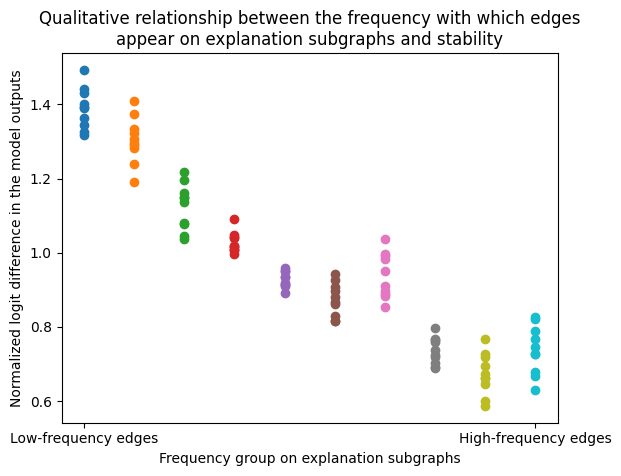

In [41]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for i in range(num_bins):
    x = [i] * num_samples
    y = results[i].detach().numpy()
    ax.scatter(x, y, label=f'Bin {i+1}')

ax.set_xlabel('Frequency group on explanation subgraphs')
ax.set_ylabel('Normalized logit difference in the model outputs')
ax.set_xticks([0, num_bins-1])  # Set ticks only at the extremes
ax.set_xticklabels(['Low-frequency edges', 'High-frequency edges'])
ax.set_title('Qualitative relationship between the frequency with which edges\nappear on explanation subgraphs and stability')
plt.show()

In [7]:
import ast
import csv

with open("explanations.csv", mode='r') as infile:
    reader = csv.reader(infile)
    next(reader)
    for row in reader:
        if row:  # Check if row is not empty
            index = row[0]
            tensor_str = row[1]
            
            # Convert the string list back to an actual list
            # Use ast.literal_eval to safely parse the string
            tensor_list = ast.literal_eval(tensor_str)

            print(tensor_list[0])


print(data.num_nodes)

0.7483364939689636
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2708
